In [1]:
import flowshape as fs
import igl
import numpy as np
import meshplot as mp
import os
import pandas as pd
from src.utilities.fin_shape_utils import plot_mesh
from src.utilities.fin_class_def import FinData
from src.utilities.functions import path_leaf
import glob2 as glob
import meshplot as mp
import trimesh

## We're just gonna go for it!

### Load fin data

In [12]:
# get list of refined fin mesh objects
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
fin_mesh_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*smoothed_fin_mesh*")))

metadata_df = pd.read_csv(os.path.join(root, "metadata", "master_metadata.csv"))
metadata_df["experiment_date"] = metadata_df["experiment_date"].astype(str)
metadata_df.head()

time_index  well_index  estimated_stage_hpf genotype  nd2_series chem_i  \
0           0           0            42.000244       wt           1    NaN   
1           0           1            42.004605       wt           2    NaN   
2           0           2            42.009037       wt           3    NaN   
3           0           3            42.013497       wt           4    NaN   
4           0           4            42.017950       wt           5    NaN   

  experiment_date  
0        20240620  
1        20240620  
2        20240620  
3        20240620  
4        20240620

### This is the norm utility in flowshape, but returns info I need for recovering original fin

In [3]:
from numpy.linalg import norm

def norm_verbose(verts):
    centroid = np.mean(verts, axis=0)
    verts -= centroid
    radii = norm(verts, axis=1)

    m = np.amax(radii)

    verts /= m
    return verts, centroid, m

### Iterate through fin meshes

In [21]:
# make col names to keep track of SH coefficients

def get_sh_colnames(max_degree):

    col_names = []
    
    for l in range(max_degree):
        
        i1 = l**2
        i2 = (l + 1) ** 2
    
        for m in range(i1, i2):
            col_name = f"sh_l{l:03}_m{m-i1:03}"
            col_names.append(col_name)
            
    return col_names


In [41]:
from tqdm import tqdm

max_degree = 25

df_list = []
for file_ind, file_path in enumerate(tqdm(fin_mesh_list[:5])):
    # get colnames
    sh_colnames = get_sh_colnames(max_degree)
    
    # extract relevant metadata
    fname = os.path.basename(file_path)
    well_ind = fname.find("well")
    date_string = fname[:well_ind-1]
    well_num = int(fname[well_ind+4:well_ind+8])
    time_ind = fname.find("time")
    time_num = int(fname[time_ind+4:time_ind+8])
    
    # match this to a row in the metadata df
    date_ft = metadata_df["experiment_date"] == date_string
    well_ft = metadata_df["well_index"] == well_num
    time_ft = metadata_df["time_index"] == time_num
    
    meta_temp = metadata_df.loc[date_ft & well_ft & time_ft, :].reset_index(drop=True)

    cv = meta_temp.loc[0, "chem_i"]
    if isinstance(cv, str):
        cvs = cv.split("_")
        chem_id = cvs[0]
        chem_time = int(cvs[2])
    else:
        chem_id = "WT"
        chem_time = np.nan
    meta_temp.loc[0, "chem_id"] = chem_id
    meta_temp.loc[0, "chem_time"] = chem_time
    
    # make temp DF to store results
    
    # load mesh
    fin_mesh = trimesh.load(file_path)
    f, v = fin_mesh.faces.copy(), fin_mesh.vertices.copy()
    
    # normalize
    vn, mu, m = norm_verbose(v.copy())
    
    # perform SH decomposition
    weights, Y_mat, vs = fs.do_mapping(vn, f, l_max=max_degree)
    
    # store results
    meta_temp.loc[0, "scale"] = m.copy()
    meta_temp.loc[0, ["xc", "yc", "zc"]] = mu.copy()
    meta_temp.loc[0, sh_colnames] = weights.copy()

    df_list.append(meta_temp)

 20%|██        | 1/5 [00:01<00:06,  1.62s/it]


IndexError: list index out of range

True

### Reconstruct

In [5]:
# standard steps
rho2 = Y_mat.dot(weights)
v_recon_raw = fs.reconstruct_shape(vs, f, rho2 )

v_recon, _, _ = norm_verbose(v_recon_raw)

# shift and scale
v_recon = v_recon * m
v_recon += mu

# make mesh
mesh_recon = fin_mesh.copy()
mesh_recon.vertices = v_recon

In [7]:
import plotly.graph_objects as go

_, lo, mo = plot_mesh(fin_mesh, surf_alpha=0.75)
_, lr, mr = plot_mesh(mesh_recon, surf_alpha=0.75)

fig = go.Figure()
fig.add_trace(lo)
fig.add_trace(mo)
fig.add_trace(lr)
fig.add_trace(mr)

fig.show()

### Align with "natural" axes of the fin

In [100]:
def gs(X, row_vecs=True, norm=True):
    if not row_vecs:
        X = X.T
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T

In [101]:
from sklearn.decomposition import PCA
from numpy.linalg import norm

# do PCA
# fin_pca = PCA(n_components=3)
# fin_pca.fit(v)
# pca_axes = fin_pca.components_
pca_axes = fin_mesh.principal_inertia_vectors

# find closest axis to vertical (surface normal). we will hold this fixed
surf_dot = np.sum(np.multiply(pca_axes, np.asarray([[0, 0, 1]])), axis=1)
si = np.argmax(surf_dot)
oi = np.asarray([0, 1, 2]) != si

# make a new set of axes
new_axes = np.zeros_like(pca_axes)
new_axes[2, :] = [0, 0, 1]
new_axes[:2, :] = pca_axes[oi, :]

# get closest orthogonal set
new_axes_o = gs(new_axes[::-1, :])[::-1, :]
print(new_axes_o)

[[-0.61483556 -0.78865533  0.        ]
 [ 0.78865533 -0.61483556  0.        ]
 [ 0.          0.          1.        ]]


In [102]:
np.sum(np.multiply(pca_axes, np.asarray([[0, 1, 0]])), axis=1)

array([-0.78557879, -0.61342028, -0.08112662])

In [103]:
fin_mesh_r = fin_mesh.copy()
new_verts = fin_mesh.vertices 
new_verts = np.matmul(new_verts, new_axes_o.T)
fin_mesh_r.vertices = new_verts

_, lo, mo = plot_mesh(fin_mesh, surf_alpha=0.75)
_, lr, mr = plot_mesh(fin_mesh_r, surf_alpha=0.75)

fig = go.Figure()
# fig.add_trace(lo)
fig.add_trace(lr)
# fig.add_trace(mo)
# fig.add_trace(lr)
# fig.add_trace(mr)
# fig.add_trace(go.Scatter3d(x=test[:, 0], y=test[:, 1], z=test[:, 2]))
fig.show()

In [76]:
dir(fin_mesh)

['__abstractmethods__',
 '__add__',
 '__annotations__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_cache',
 '_data',
 '_visual',
 'apply_obb',
 'apply_scale',
 'apply_transform',
 'apply_translation',
 'area',
 'area_faces',
 'body_count',
 'bounding_box',
 'bounding_box_oriented',
 'bounding_cylinder',
 'bounding_primitive',
 'bounding_sphere',
 'bounds',
 'center_mass',
 'centroid',
 'compute_stable_poses',
 'contains',
 'convert_units',
 'convex_decomposition',
 'convex_hull',
 'copy',
 'density',
 'difference',
 'edges',
 'edges_face',
 'edges_sorted',
 'edges_sorted_tree',
 'edges_sparse

In [89]:
test = fin_mesh.bounding_box.vertices

In [92]:
print(fin_mesh.principal_inertia_vectors)

[[ 0.41102463  0.89917298  0.1501556 ]
 [ 0.86897956 -0.43623424  0.23361125]
 [-0.27555994 -0.03446216  0.96066596]]


In [93]:
print(pca_axes)

[[ 0.32946457  0.93693061  0.11667963]
 [ 0.9096434  -0.34809683  0.226666  ]
 [-0.25298612 -0.03145844  0.96695832]]


#### ... that is NOT it. Let's see if flowshape can do better

In [46]:
rec2 = fs.reconstruct_shape(vs, f, rho2 )
mp.plot(rec2,f, c = rho2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.056183…

### Are SH coefficients scale-invariant?
My expectation is yes

In [50]:
v0, f0 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
v0_big = v0*100

w0, Y_mat, vs = fs.do_mapping(v0, f0, l_max=15)
w0_big, Y_mat, vs = fs.do_mapping(v0_big, f0, l_max=15)

In [51]:
np.all(np.round(w0, 5) == np.round(w0_big, 5))

True

Yep! We will need an extra scaling coefficient to fully recapitulate the data

### Are SH coefficents rotationally invariant?
Expectation is that they are not

In [53]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# Example point cloud (Nx3 array)
# points = np.random.rand(100, 3)

# Generate a random rotation
rotation = R.random()  # Generates a random 3D rotation
rotation_matrix = rotation.as_matrix()

# Rotate the point cloud
# rotated_points = points @ rotation_matrix.T

v1, f1 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
v1_rot = v1 @ rotation_matrix.T

w1, _, _ = fs.do_mapping(v1, f1, l_max=15)
w1_rot, _, _ = fs.do_mapping(v1_rot, f1, l_max=15)

np.all(np.round(w1, 5) == np.round(w1_rot, 5))

False

Cool cool cool. 

### Look at recon error

In [77]:
from tqdm import tqdm

v2, f2 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
# print(np.max(v2))
# # normalize the scaling of the mesh
v2_norm = fs.normalize(v2.copy())

l_vec = np.arange(1, 76, 5)
r2_vec = []
for l in tqdm(l_vec):
    w2, Y2, vs2 = fs.do_mapping(v2_norm, f2, l_max=l)
    rho2 = Y2.dot(w2)
    rec2 = fs.reconstruct_shape(vs2, f2, rho2)

    r2_norm = fs.normalize(rec2.copy())
    

    r2_vec.append(np.sum((v2_norm - r2_norm)**2))

# mp.plot(rec2, f2, c=rho2)

100%|██████████| 15/15 [02:08<00:00,  8.60s/it]


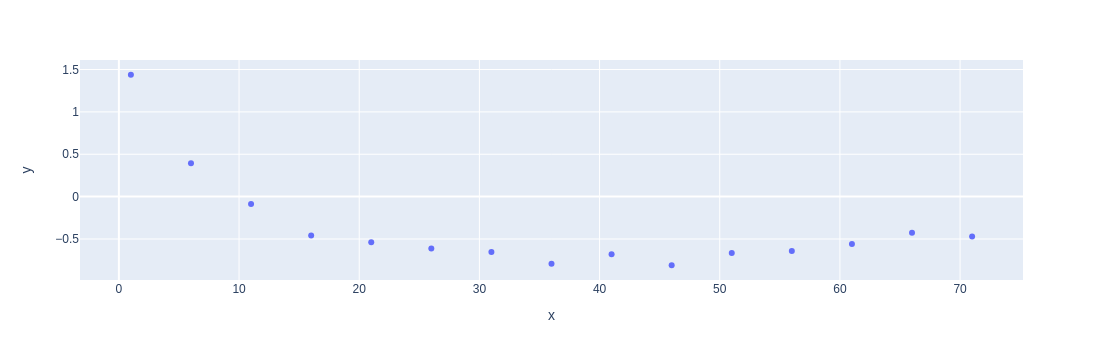

In [82]:
import plotly.express as px

n_factor = np.sum((v2_norm - 0)**2)

fig = px.scatter(x=l_vec, y=np.log10(r2_vec / n_factor * 100))
fig.show()

In [75]:
np.arange(1, 75, 5)

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71])